In [91]:
import os
import glob
import json
import torch
import pandas as pd

import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
from matplotlib import pyplot as plt
%matplotlib inline

from tsvar.plotting import load_outputs

In [2]:
NEURIPS_RCPARAMS = {
    "figure.autolayout": False,         # Makes sure nothing the feature is neat & tight.
    "figure.figsize": (5.5, 2.95),      # Text width: 5.5in (double figure minus spacing 0.2in).
    "figure.dpi": 150,                  # Displays figures nicely in notebooks.
    "axes.linewidth": 0.5,              # Matplotlib's current default is 0.8.
    "xtick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.major.width": 0.5,
    "ytick.minor.width": 0.5,
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",             # use serif rather than sans-serif
    "font.serif": "Times New Roman",    # use "Times New Roman" as the standard font
    "font.size": 7,
    "axes.titlesize": 7,                # LaTeX default is 10pt font.
    "axes.labelsize": 7,                # LaTeX default is 10pt font.
    "legend.fontsize": 7,               # Make the legend/label fonts a little smaller
    "legend.frameon": True,             # Remove the black frame around the legend
    "patch.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "lines.linewidth": 1.0,
    "lines.markersize": 4,
    "grid.linewidth": 0.3,
    "pgf.texsystem": "xelatex",         # use Xelatex which is TTF font aware
    "pgf.rcfonts": False,               # Use pgf.preamble, ignore standard Matplotlib RC
    "pgf.preamble": [
        r'\usepackage{fontspec}',
        r'\usepackage{unicode-math}',
        r'\setmainfont{Times New Roman}',
    ],
    'errorbar.capsize': 3.0,
}

matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.rcParams.update(NEURIPS_RCPARAMS)

In [3]:
EXP_DIR = "../output/dimRegime-1/"

In [4]:
def extract_exp_name(output_fname):
    """Return the experiment name for an output filename"""
    return output_fname.split(os.path.sep)[-2]

In [5]:
def process_param_file(param_fname):
    """Process a parameter file"""
    with open(param_fname, 'r') as f:
        data = json.load(f)
    series = pd.concat((
        pd.Series(data['params']).apply(np.array), 
        pd.Series(data)
    ))
    del series['params']
    series['expId'] = os.path.split(param_fname)[0]
    return series


def extract_param_df(exp_dir):
    param_file_list = glob.glob(os.path.join(exp_dir, '*', 'params.json'))
    param_df = pd.DataFrame(list(map(process_param_file, param_file_list)))
    return param_df

In [68]:
import tsvar

def process_mle(data):
    """Process the output of a MLE run"""
    series = pd.Series(data['coeffs']).apply(np.array)
    series['conv'] = data['conv']
    series['history'] = data['history']
    # Add prefix
    series = series.rename({col:'mle_' + col for col in series.index})
    return series


def process_bbvi(data, dim=None):
    """Process the output of a BBVI run"""
    series = pd.Series()
    series['loc'] = np.array(data['coeffs']['loc'])
    series['log_scale'] = np.array(data['coeffs']['log-scale'])
    post = tsvar.posteriors.LogNormalPosterior()
    coeffs_mean = post.mean(torch.tensor(series['loc']), torch.tensor(series['log_scale'])).numpy()
    coeffs_mode = post.mode(torch.tensor(series['loc']), torch.tensor(series['log_scale'])).numpy()
    series['coeffs_mean'] = coeffs_mean
    series['coeffs_mode'] = coeffs_mode
    if dim:
        series['adj_mean'] = np.reshape(coeffs_mean[dim+dim**2:], (dim , dim))
        series['adj_mode'] = np.reshape(coeffs_mean[dim+dim**2:], (dim , dim))
    series['conv'] = data['conv']
    series['history'] = data['history']
    # Add prefix
    series = series.rename({col:'bbvi_' + col for col in series.index})
    return series


def process_vi(data):
    series = pd.Series(data['coeffs']).apply(np.array)
    series['conv'] = data['conv']
    series['history'] = data['history']
    # Extract mean/model posterior for coeffs
    model = tsvar.models.WoldModelVariational()
    series['adj_mode'] = model.alpha_posterior_mean(as_po=series['as_po'], ar_po=series['ar_po'])[1:,:]
    series['adj_mean'] = model.alpha_posterior_mode(as_po=series['as_po'], ar_po=series['ar_po'])[1:,:]
    # Add prefix
    series = series.rename({col:'vi_' + col for col in series.index})
    return series


def process_vi_fixed_beta(data):
    series = pd.Series(data['coeffs']).apply(np.array)
    series['conv'] = data['conv']
    series['history'] = data['history']
    # Extract mean/model posterior for coeffs
    model = tsvar.models.WoldModelVariationalFixedBeta()
    series['adj_mode'] = model.alpha_posterior_mean(as_po=series['as_po'], ar_po=series['ar_po'])[1:,:]
    series['adj_mean'] = model.alpha_posterior_mode(as_po=series['as_po'], ar_po=series['ar_po'])[1:,:]
    # Add prefix
    series = series.rename({col:'vi_fixed_beta_' + col for col in series.index})
    return series


def process_gb(data):
    series = pd.Series(data['coeffs']).apply(np.array)
    series['conv'] = data['conv']
    series['history'] = data['history']
    # Extract normalized adjacency
    series['adj_normed'] = series['adjacency'] / series['adjacency'].sum(axis=1)
    # Add prefix
    series = series.rename({col:'gb_' + col for col in series.index})
    return series


def process_output_file(output_fname, param_df):
    """Process an output file"""
    with open(output_fname, 'r') as f:
        all_data = json.load(f)
    # Extract experiment Id and output Id
    exp_id, output_idx = os.path.split(output_fname)
    # Extract number of dimensions
    dim = int(param_df.loc[param_df.expId == exp_id].iloc[0].dim)
    # Extract the output for each inference method
    series_list = list()
    print(f"Process file: {output_fname}...", end='\r', flush=True)
    for method, data in all_data.items():
        if method == 'mle':
            s = process_mle(data)
            series_list.append(s)
        if method == 'bbvi':
            s = process_bbvi(data, dim=dim)
            series_list.append(s)
        if method == 'vi':
            s = process_vi(data)
            series_list.append(s)
        if method == 'vi-fixed-beta':
            s = process_vi_fixed_beta(data)
            series_list.append(s)
        if method == 'gb':
            s = process_gb(data)
            series_list.append(s)
    # Add experiment name `expId` and output index `outputIdx`
    if len(series_list) > 0:
        series = pd.concat(series_list)
        series['expId'] = exp_id
        series['outputIdx'] = output_idx
        series['dim_o'] = dim
        return series
    else:
        print('Failed:', output_fname)
        return pd.Series()


def extract_output_df(exp_dir, param_df):
    output_file_list = sorted(glob.glob(os.path.join(exp_dir, '*', 'output-*.json')))
    output_df = pd.DataFrame([process_output_file(fp, param_df) for fp in output_file_list])
    print()
    return output_df

In [69]:
def load_outputs(exp_dir):
    # Load parameters
    param_df = extract_param_df(exp_dir)
    # Load outputs
    output_df = extract_output_df(exp_dir, param_df=param_df)
    # Merge
    df = pd.merge(output_df, param_df, on='expId', suffixes=('', '_true'), validate='m:1')
    return df

df = load_outputs(EXP_DIR)
df.head()

Process file: ../output/dimRegime-1/g09-d15-n075000-1588617235/output-04.json...


,mle_baseline,mle_beta,mle_adjacency,mle_conv,mle_history,bbvi_loc,bbvi_log_scale,bbvi_coeffs_mean,bbvi_coeffs_mode,bbvi_adj_mean,...,expId,outputIdx,dim_o,baseline,beta,adjacency,dim,max_jumps,sim_seed_list,gen_seed
0,"[0.02036429157338015, 0.008839677545564724, 0....","[[1.0814376157365175, 1e-10, 1e-10, 0.00651545...","[[1e-10, 0.032304468553800855, 0.0267240311001...",False,"{'coeffs': [[0.5546854606061864, 0.50997656035...","[-2.5094354152679443, -3.392083168029785, -5.2...","[-3.12803316116333, -2.2512359619140625, -0.85...","[0.0813921843569819, 0.03382543031843895, 0.00...","[0.0811582607540318, 0.03326781925839516, 0.00...","[[1.1910164476549706e-08, 0.037432675006846314...",...,../output/dimRegime-1/g01-d50-n250000-1588617244,output-00.json,50,"[0.0421, 0.0303, 0.0039, 0.0071, 0.012, 0.0426...","[[0.7619, 0.6576, 0.7492, 0.1943, 0.0506, 0.34...","[[0.0, 0.0553, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",50,250000,"[1382663778, 682980078, 1060135411, 789439264,...",432195610
1,"[0.016607654891951616, 0.00750491162413825, 0....","[[1.0098020450318013, 1e-10, 2.339608468428166...","[[1e-10, 0.017569010398445283, 1e-10, 1e-10, 1...",False,"{'coeffs': [[0.5112434052292395, 0.51140249079...","[-2.700204372406006, -3.581641674041748, -5.95...","[-3.059098720550537, -2.040208101272583, -0.77...","[0.06726581228562396, 0.02806613866616276, 0.0...","[0.06704395735519819, 0.02736358663856978, 0.0...","[[6.815630911437836e-07, 1.3478714031580147e-0...",...,../output/dimRegime-1/g01-d50-n250000-1588617244,output-01.json,50,"[0.0421, 0.0303, 0.0039, 0.0071, 0.012, 0.0426...","[[0.7619, 0.6576, 0.7492, 0.1943, 0.0506, 0.34...","[[0.0, 0.0553, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",50,250000,"[1382663778, 682980078, 1060135411, 789439264,...",432195610
2,"[0.012123953414766835, 0.04111459132827428, 0....","[[1e-10, 1e-10, 1.1411134070303546, 1e-10, 0.8...","[[0.07306633846544329, 0.010583161240727909, 0...",False,"{'coeffs': [[0.007613495489546469, 0.510774759...","[-3.8068673610687256, -3.150925874710083, -3.5...","[-2.5843803882598877, -3.2772719860076904, -3....","[0.022280987285944635, 0.0428429549763427, 0.0...","[0.022091574694156076, 0.04275156369339311, 0....","[[0.07384119437498506, 3.6717308063997185e-09,...",...,../output/dimRegime-1/g02-d10-n050000-1588617233,output-00.json,10,"[0.0185, 0.0416, 0.0213, 0.0001, 0.03, 0.0483,...","[[0.6034, 0.3162, 0.3896, 0.4102, 0.2521, 0.03...","[[0.0926, 0.0, 0.0, 0.1902, 0.0, 0.109, 0.1255...",10,50000,"[948684003, 209429041, 13141390, 1544385636, 1...",198096028
3,"[0.013579752230765895, 0.020072324744037296, 0...","[[0.7084584337413418, 1e-10, 1.471632550012279...","[[0.09766644640709292, 0.007301266649198635, 1...",False,"{'coeffs': [[0.7477231590194752, 0.02035407482...","[-3.6459150314331055, -3.2114293575286865, -3....","[-2.6323695182800293, -3.0971219539642334, -2....","[0.026165077941421075, 0.04034011948252533, 0....","[0.02596292361071758, 0.04021679826144065, 0.0...","[[0.06499392853602248, 4.608889928678684e-09, ...",...,../output/dimRegime-1/g02-d10-n050000-1588617233,output-02.json,10,"[0.0185, 0.0416, 0.0213, 0.0001, 0.03, 0.0483,...","[[0.6034, 0.3162, 0.3896, 0.4102, 0.2521, 0.03...","[[0.0926, 0.0, 0.0, 0.1902, 0.0, 0.109, 0.1255...",10,50000,"[948684003, 209429041, 13141390, 1544385636, 1...",198096028
4,"[0.009084346334146188, 0.03607371975003274, 0....","[[1e-10, 3.968441915441984, 9.118912654507403,...","[[0.057974960343959735, 1e-10, 0.0735559214025...",False,"{'coeffs': [[0.5134387820133792, 0.50850816594...","[-3.9416565895080566, -3.0552031993865967, -3....","[-2.339508295059204, -3.2399709224700928, -2.6...","[0.01950640281571704, 0.047149293719811934, 0....","[0.01923651981393653, 0.0470409349821836, 0.02...","[[0.061032512944166985, 1.8273236228548976e-06...",...,../output/dimRegime-1/g02-d10-n050000-1588617233,output-03.json,10,"[0.0185, 0.0416, 0.0213, 0.0001, 0.03, 0.0483,...","[[0.6034, 0.3162, 0.3896, 0.4102, 0.2521, 0.03...","[[0.0926, 0.0, 0.0, 0.1902, 0.0, 

In [78]:
THRESHOLD = 0.05

def make_metric(func, col, col_true='adjacency', **kwargs):
    return df.apply(lambda row: func(row[col].flatten(), row[col_true].flatten(), **kwargs), axis=1)

def make_perf(df, func, prefix, suf_col_dict, **kwargs):
    col_list = list()
    for suf, col in suf_col_dict.items():
        name = '_'.join([prefix, suf])
        df[name] = make_metric(func, col=col, **kwargs)
        col_list.append(name)
    return col_list

suf_col_dict={
    'mle': 'mle_adjacency', 
    'bbvi_mean': 'bbvi_adj_mean', 
    'bbvi_mode': 'bbvi_adj_mode',
    'vi_mean': 'vi_adj_mean',
    'vi_mode': 'vi_adj_mode',
    'vi_fixed_beta_mean': 'vi_fixed_beta_adj_mean',
    'vi_fixed_beta_mode': 'vi_fixed_beta_adj_mode',
    'gb': 'gb_adj_normed',
}

cols_acc = make_perf(df, tsvar.utils.metrics.accuracy, prefix='acc', 
                     suf_col_dict=suf_col_dict, threshold=THRESHOLD)

cols_relerr = make_perf(df, tsvar.utils.metrics.relerr, prefix='relerr', 
                        suf_col_dict=suf_col_dict)

cols_f1score = make_perf(df, tsvar.utils.metrics.fscore, prefix='f1score', 
                         suf_col_dict=suf_col_dict)

In [80]:
df_plot = df[cols_acc + cols_relerr + cols_f1score + ['dim']].groupby('dim').agg(['min', 'max', 'mean', 'std', 'count'])
df_plot

acc_mle                                     acc_bbvi_mean                                      ... f1score_vi_fixed_beta_mode                                     f1score_gb                                    
          min       max      mean       std count           min       max      mean       std count  ...                        min       max      mean       std count        min       max      mean       std count
dim                                                                                                  ...                                                                                                              
5    0.560000  0.880000  0.720000  0.116619     5      0.960000  1.000000  0.984000  0.021909     5  ...                   1.000000  1.000000  1.000000  0.000000     5   0.727273  0.787879  0.763547  0.025907     5
10   0.560000  0.970000  0.822308  0.147544    13      0.940000  1.000000  0.965385  0.021454    13  ...                   0.967033  1.000000  0.992618  0.011125    13   0.760870  0.863636  0.801800  0.025374    13
15   0.640000  0.942222  0.852650  0.110067    13      0.920000  0.968889  0.947692  0.013475    13  ...                   0.948052  0.988764  0.967008  0.012629    13   0.645669  0.729730  0.697416  0.024107    13
20   0.865000  0.932500  0.912500  0.025981     6      0.955000  0.965000  0.960417  0.003323     6  ...                   0.953271  0.967742  0.961339  0.005831     6   0.683417  0.718447  0.698460  0.014555     6
30   0.917778  0.917778  0.917778       NaN     1      0.953333  0.953333  0.953333       NaN     1  ...                   0.919598  0.919598  0.919598       NaN     1   0.590786  0.590786  0.590786       NaN     1
35   0.928980  0.947755  0.940136  0.009875     3      0.960816  0.963265  0.961905  0.001247     3  ...                   0.909502  0.927473  0.919110  0.009050     3   0.542857  0.574766  0.554359  0.017721     3
40   0.910000  0.938125  0.920417  0.015415     3      0.959375  0.964375  0.962083  0.002526     3  ...                   0.875240  0.884758  0.881121  0.005141     3   0.503906  0.554455  0.531776  0.025671     3
50   0.946000  0.948400  0.947200  0.001697     2      0.965600  0.970400  0.968000  0.003394     2  ...                   0.855422  0.874627  0.865024  0.013580     2   0.496988  0.515337  0.506163  0.012975     2

[8 rows x 120 columns]

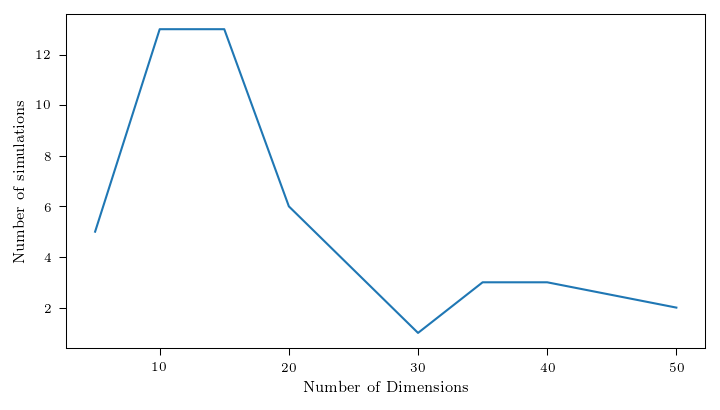

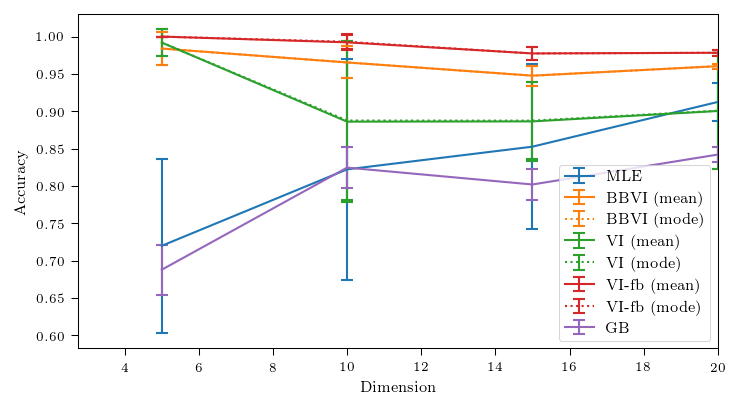

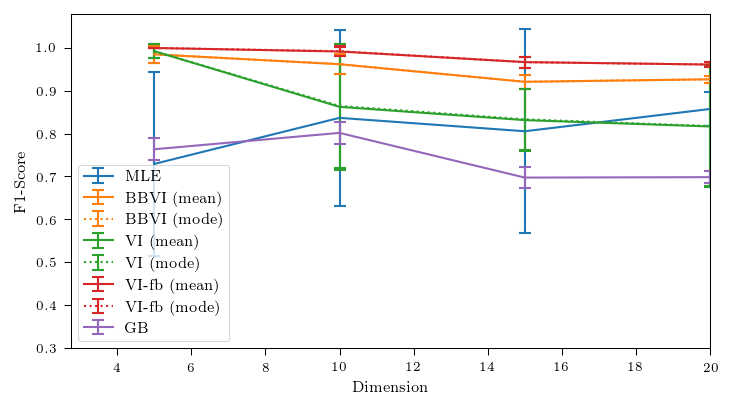

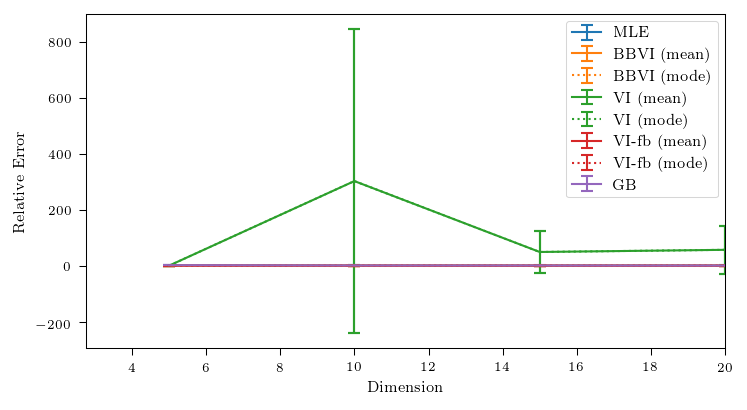

In [90]:
plot_meta_data = [
    ('acc', 'Accuracy'),
    ('f1score', 'F1-Score'), 
    ('relerr', 'Relative Error')
]

queries_list = [
    ('mle',                'MLE',          'C0', '-'), 
    ('bbvi_mean',          'BBVI (mean)',  'C1', '-'), 
    ('bbvi_mode',          'BBVI (mode)',  'C1', ':'),
    ('vi_mean',            'VI (mean)',    'C2', '-'),
    ('vi_mode',            'VI (mode)',    'C2', ':'),
    ('vi_fixed_beta_mean', 'VI-fb (mean)', 'C3', '-'),
    ('vi_fixed_beta_mode', 'VI-fb (mode)', 'C3', ':'),
    ('gb',                 'GB',           'C4', '-'),
]


plt.figure()
plt.plot(df_plot.index, df_plot['acc_mle']['count'])
plt.ylabel('Number of simulations')
plt.xlabel('Number of Dimensions')


for prefix, ylabel in plot_meta_data:

    plt.figure()
    for suf, label, color, ls in queries_list:
        col = '_'.join([prefix, suf])
        plt.errorbar(df_plot.index, df_plot[col]['mean'], yerr=df_plot[col]['std'], 
                     label=label, color=color, linestyle=ls)
    plt.legend()
    plt.xlabel('Dimension')
    #plt.xscale('log')
    plt.ylabel(ylabel);
    
    plt.xlim(right=20)